In [1]:
#!/usr/bin/env python3

import gzip
import pickle
import argparse
import copy
import gc
import glob
import json
import os
import random
import sys
import time
import uuid
import warnings
from typing import Callable, Dict, List, Tuple, Any


import matplotlib.pyplot as plt
import copy

import numpy as np
import pandas as pd
import tqdm
from loguru import logger
from sklearn import pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import pickle

import shap

from nn import *

# import dotenv


# Way to dynamically change the number of jobs at run time
def get_num_jobs(default_jobs: int) -> int:
    """This function provides a way to override the number of jobs specified
    in the command line arguments dynamically.
    A file called num_jobs.txt can be created and the first line
    should contain the number of jobs.

    Args:
        default_jobs (int): default value if it is not overridden

    Returns:
        int: number of jobs to run
    """
    if not os.path.exists("num_jobs.txt"):
        return default_jobs
    with open("num_jobs.txt") as f:
        try:
            line = f.readlines()[0].strip()
            temp_jobs = int(line)
            if temp_jobs > 0 and temp_jobs < 20:
                logger.info(f"NUM_JOBS override: {temp_jobs}")
                return temp_jobs
        except:
            return default_jobs
    return default_jobs


def random_seed() -> None:
    np.random.seed(0)
    random.seed(0)


def get_save_filename() -> str:
    return f"{str(uuid.uuid4())}.csv.gz"


def gc_collect() -> None:
    for i in range(3):
        for j in range(3):
            gc.collect(j)


def get_columns_and_types(thisdf: pd.DataFrame) -> Dict[str, List[str]]:
    """For each feature set type, get the relevant columns.

    Args:
        thisdf (pd.DataFrame): Input dataframe.

    Returns:
        Dict[str, List[str]]: Dictionary that maps the feature type to the
            list of columns to the feature type.
    """
    columns = [c for c in thisdf.columns if not c.startswith("an_")]

    def get_columns(columns: List[str], start_string: str) -> List[str]:
        columns = [c for c in columns if c.startswith(start_string)]
        columns = [c for c in columns if "head" not in c and "tail" not in c]
        columns = [c for c in columns if "begin" not in c and "end" not in c]
        columns = [c for c in columns if "filesize" not in c]
        
        # DO WE WANT RAW FOURIER VALUES
        columns = [c for c in columns if "fourier.value" not in c.lower()]
        
        return columns

    baseline_columns = get_columns(columns, "baseline")
    advanced_columns = get_columns(columns, "advanced")
    fourier_columns = get_columns(columns, "fourier")
    fourier_min_columns = [
        "fourier.stat.1byte.autocorr",
        "fourier.stat.1byte.mean",
        "fourier.stat.1byte.std",
        "fourier.stat.1byte.chisq",
        "fourier.stat.1byte.moment.2",
        "fourier.stat.1byte.moment.3",
        "fourier.stat.1byte.moment.4",
        "fourier.stat.1byte.moment.5",
    ]

    baseline_and_advanced = list(set(baseline_columns + advanced_columns))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns))
    advanced_and_fourier = list(set(advanced_columns + fourier_columns))
    baseline_and_fourier_min = list(set(baseline_columns + fourier_min_columns))
    advanced_and_fourier_min = list(set(advanced_columns + fourier_min_columns))

    baseline_advanced_fourier = list(
        set(baseline_columns + advanced_columns + fourier_columns)
    )
    baseline_advanced_and_fourier_min = list(
        set(baseline_columns + advanced_columns + fourier_min_columns)
    )

    rv = {
        "baseline-advanced-and-fourier": baseline_advanced_fourier,
    }

    #logger.info(f"Features = {rv}")

    return rv


def get_annotation_columns(thisdf: pd.DataFrame) -> List[str]:
    """List of columns used for annotation.

    Args:
        thisdf (pd.DataFrame): Input dataframe.

    Returns:
        _type_: List of columns
    """
    return [c for c in thisdf.columns if c.startswith("an_")]


def annotate_df_with_additional_fields(
    name: str, dataframe: pd.DataFrame
) -> pd.DataFrame:
    """Add some metadata to each dataframe

    Args:
        name (str): Name of the csv/parquet file
        dataframe (pd.DataFrame): Dataframe

    Returns:
        pd.DataFrame: Dataframe with additional information
    """
    if "base32" in name or "b32" in name:
        dataframe["an_is_base32"] = 1
    else:
        dataframe["an_is_base32"] = 0
    dataframe["an_is_base32"] = dataframe["an_is_base32"].astype(np.bool_)

    if "encrypt" in name:
        dataframe["is_encrypted"] = 1
    else:
        dataframe["is_encrypted"] = 0
    dataframe["is_encrypted"] = dataframe["is_encrypted"].astype(np.bool_)

    if "v1" in name:
        dataframe["an_v1_encrypted"] = 1
    else:
        dataframe["an_v1_encrypted"] = 0
    dataframe["an_v1_encrypted"] = dataframe["an_v1_encrypted"].astype(np.bool_)

    if "v2" in name:
        dataframe["an_v2_encrypted"] = 1
    else:
        dataframe["an_v2_encrypted"] = 0
    dataframe["an_v2_encrypted"] = dataframe["an_v2_encrypted"].astype(np.bool_)

    if "v3" in name:
        dataframe["an_v3_encrypted"] = 1
    else:
        dataframe["an_v3_encrypted"] = 0
    dataframe["an_v3_encrypted"] = dataframe["an_v3_encrypted"].astype(np.bool_)

    def is_webp(filename: str) -> int:
        return 1 if ".webp" in filename else 0

    dataframe["an_is_webp"] = (
        dataframe["extended.base_filename"].map(is_webp).astype(np.bool_)
    )

    return dataframe


def load_data(input_directory: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load all pandas data files from a directory and annotate them with
    additional fields

    Args:
        input_directory (str): input directory

    Returns:
        pd.DataFrame: A combined dataframe of all files (Train)
        pd.DataFrame: A combined dataframe of all files (Test)
    """

    interesting_files = [
        "plaintext.base32.combined.csv.gz",
        "expanded.base32.des3.csv.gz",
        "n1.plaintext.base32.csv.gz",
        "expanded_encrypted_v3.csv.gz",
        "n1.expanded.plaintext.csv.gz",
        "n1.expanded.pyencrypted_v2.csv.gz",
        "n1.expanded.pyencrypted_v1.base32.csv.gz",
        "expanded.des3.csv.gz",
        "n1.expanded.pyencrypted_v2.base32.csv.gz",
        "expanded.pyencrypted_v1.csv.gz",
        "expanded.pyencrypted_v2.base32.csv.gz",
        "expanded_encrypted_v3_base32.csv.gz",
        "n1.expanded.pyencrypted_v3.base32.csv.gz",
        "plaintext.combined.csv.gz",
        "plaintext.expanded.csv.gz",
        "expanded.pyencrypted_v2.csv.gz",
        "expanded.plaintext.base32.csv.gz",
        "n1.expanded.pyencrypted_v3.csv.gz",
        "n1.expanded.plaintext.base32.csv.gz",
        "n1.plaintext.csv.gz",
        "expanded.pyencrypted_v1.b32.csv.gz",
        "n1.expanded.pyencrypted_v1.csv.gz",
    ]
    p = 0.1
    logger.info("Loading dataframes")
    dataframes = {
        # f: pd.read_csv(f, skiprows=lambda i: i > 0 and random.random() > p)
        f: pd.read_csv(f)  # , nrows=50)
        for f in tqdm.tqdm(
            glob.glob(f"{input_directory}{os.path.sep}*.csv.gz"), desc="Loading data"
        )
        if os.path.basename(f).lower() in interesting_files
    }

    logger.info("Annotating dataframes with additional fields")
    dataframes = {
        f: annotate_df_with_additional_fields(f, df) for f, df in dataframes.items()
    }

    logger.info("Combining test dataframes into a single dataframe")
    test_df = (
        pd.concat([df for fname, df in dataframes.items() if "n1." in fname.lower()])
        .sample(frac=1)
        .reset_index(drop=True)
    )

    logger.info("Combining train dataframes into a single dataframe")
    train_df = (
        pd.concat(
            [df for fname, df in dataframes.items() if "n1." not in fname.lower()]
        )
        .sample(frac=1)
        .reset_index(drop=True)
    )

    
    logger.info("done...")
    return train_df, test_df
  

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-07-16 13:53:48.824346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
master_train_df, master_test_df = load_data("/Users/phantom/dev/NapierOne")

2023-07-16 13:53:52.977 | INFO     | __main__:load_data:245 - Loading dataframes
Loading data: 100%|█████████████████████████████████████████████████████████████████████████████| 53/53 [04:48<00:00,  5.45s/it]
2023-07-16 13:58:41.891 | INFO     | __main__:load_data:255 - Annotating dataframes with additional fields
2023-07-16 13:58:42.587 | INFO     | __main__:load_data:260 - Combining test dataframes into a single dataframe
2023-07-16 13:58:46.182 | INFO     | __main__:load_data:267 - Combining train dataframes into a single dataframe
2023-07-16 14:04:09.854 | INFO     | __main__:load_data:277 - done...


In [3]:
annot_columns = get_annotation_columns(master_train_df)
fscolumns = get_columns_and_types(master_train_df)["baseline-advanced-and-fourier"]
colnames = [c for c in fscolumns if "is_encrypted" not in c]
colnames = [c for c in colnames if c not in annot_columns]
colnames = [c for c in colnames if not c.startswith("an_")]
colnames = [c for c in colnames if not c.lower() == "extended.base_filename"]
            
            
train_df=master_train_df[colnames + ["is_encrypted"]].copy()
test_df=master_test_df[colnames + ["is_encrypted"]].copy()
            
print(f"{train_df.shape=}")
            
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = train_df[colnames]
y_train = train_df["is_encrypted"].to_numpy().flatten()
X_test = test_df[colnames]
y_test = test_df["is_encrypted"].to_numpy().flatten()
            
gc_collect()        
print("Creating NN MODEL")
pline = NNModel(input_dim=X_train.shape[-1])
print("alling NN.fit")
pline.fit(X_train, y_train)

train_df.shape=(970236, 82)
Creating NN MODEL
alling NN.fit
Epoch 1/50
27288/27288 [==============================] - 77s 3ms/step - loss: 0.5583 - binary_accuracy: 0.6375 - auc: 0.7221 - val_loss: 0.5611 - val_binary_accuracy: 0.6344 - val_auc: 0.7297
Epoch 2/50
27288/27288 [==============================] - 59s 2ms/step - loss: 0.5326 - binary_accuracy: 0.6547 - auc: 0.7506 - val_loss: 0.5261 - val_binary_accuracy: 0.6629 - val_auc: 0.7587
Epoch 3/50
27288/27288 [==============================] - 46s 2ms/step - loss: 0.5257 - binary_accuracy: 0.6615 - auc: 0.7589 - val_loss: 0.5153 - val_binary_accuracy: 0.6716 - val_auc: 0.7767
Epoch 4/50
27288/27288 [==============================] - 55s 2ms/step - loss: 0.5197 - binary_accuracy: 0.6666 - auc: 0.7655 - val_loss: 0.5271 - val_binary_accuracy: 0.6564 - val_auc: 0.7637
Epoch 5/50
27288/27288 [==============================] - 64s 2ms/step - loss: 0.5158 - binary_accuracy: 0.6695 - auc: 0.7691 - val_loss: 0.5117 - val_binary_accuracy: 

Epoch 43/50
27288/27288 [==============================] - 47s 2ms/step - loss: 0.4805 - binary_accuracy: 0.6967 - auc: 0.8052 - val_loss: 0.4794 - val_binary_accuracy: 0.6907 - val_auc: 0.8085
Epoch 44/50
27288/27288 [==============================] - 52s 2ms/step - loss: 0.4802 - binary_accuracy: 0.6969 - auc: 0.8055 - val_loss: 0.4777 - val_binary_accuracy: 0.6987 - val_auc: 0.8096
Epoch 45/50
27288/27288 [==============================] - 68s 2ms/step - loss: 0.4802 - binary_accuracy: 0.6972 - auc: 0.8052 - val_loss: 0.4766 - val_binary_accuracy: 0.6965 - val_auc: 0.8084
Epoch 46/50
27288/27288 [==============================] - 58s 2ms/step - loss: 0.4798 - binary_accuracy: 0.6967 - auc: 0.8054 - val_loss: 0.4777 - val_binary_accuracy: 0.7003 - val_auc: 0.8099
Epoch 47/50
27288/27288 [==============================] - 55s 2ms/step - loss: 0.4797 - binary_accuracy: 0.6974 - auc: 0.8059 - val_loss: 0.4792 - val_binary_accuracy: 0.6965 - val_auc: 0.8090
Epoch 48/50
27288/27288 [=====

In [7]:
print("Transforming X_train")
tr_X_train = pline.scalar.transform(X_train)
print("Transoforming X_test")
#X_test = test_df[colnames]
tr_X_test = pline.scalar.transform(X_test)
classif_fn = pline.model.predict

print("Creating shap kernel explainer")
explainer = shap.Explainer(
    pline.model,
    shap.sample(tr_X_train, 800))
    #tr_X_train)

print("Getting shap values")
explanation = explainer(
    shap.sample(tr_X_test, 800), # tr_X_train
    )

explanation2 = shap.Explanation(
    values=explanation.values, 
    base_values=explanation.base_values, 
    data=explanation.data,
    feature_names=colnames
)
shap.plots.beeswarm(explanation2)

# print("Final prediction")
# shap.summary_plot(
#     shap_values,
#     tr_X_test,
#     feature_names=colnames)

Transforming X_train
Transoforming X_test
Creating shap kernel explainer
Getting shap values


Permutation explainer: 801it [01:08, 10.58it/s]                                                                                 


IndexError: too many indices for array

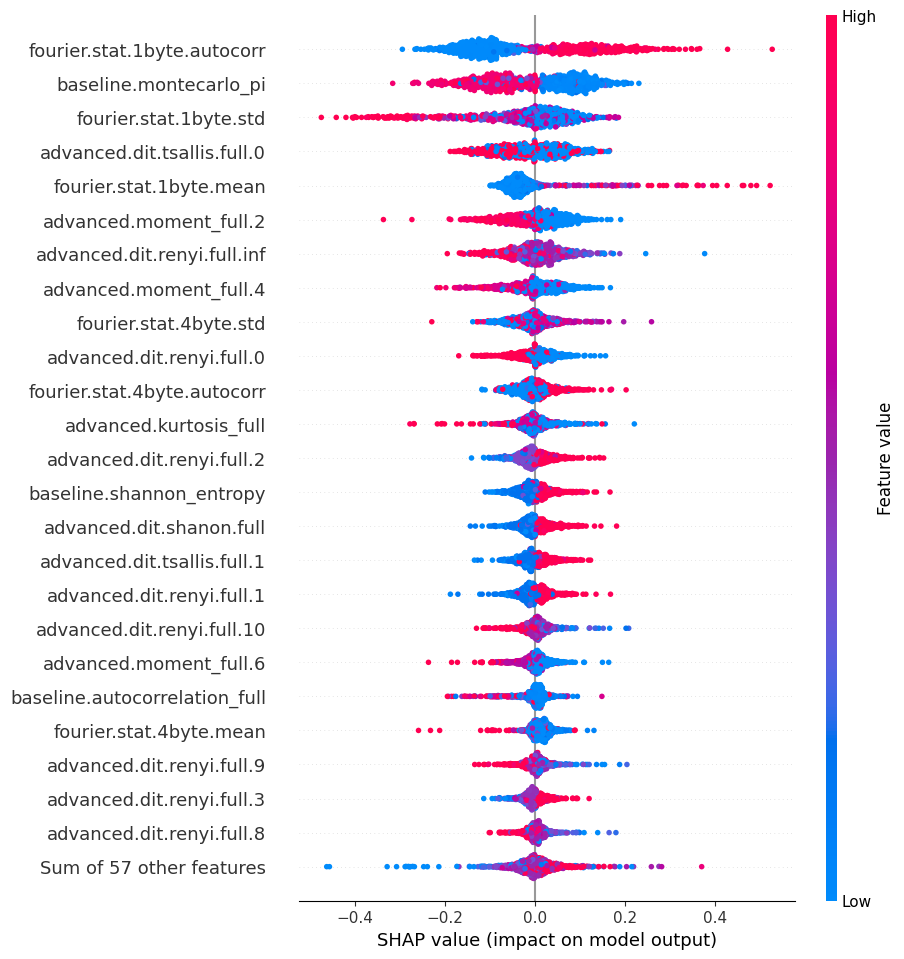

In [9]:
shap.plots.beeswarm(explanation2, max_display=25)

In [ ]:
print("Final prediction")
shap.summary_plot(
    shap_values,
    tr_X_train,
    feature_names=colnames,
    max_display=25)

In [ ]:
# import pickle
# with open("nn-shap-values-all-features-no-fourier-values.pkl", "wb") as f:
#     pickle.dump(shap_values, file=f, protocol=pickle.HIGHEST_PROTOCOL)